# Machine Learning con Applicazioni
## Riccardo Riva - Matricola 984070

### Dataset

Per questo progetto computazionale si è utilizzato il dataset FER-2013:
https://www.kaggle.com/datasets/msambare/fer2013

Il dataset FER (Facial Expression Recognition) è una raccolta di immagini di volti utilizzato per sviluppare algoritmi di riconoscimento delle espressioni facciali. Ogni immagine è etichettata con una delle sette categorie di emozioni principali: *felicità, sorpresa, rabbia, paura, tristezza, disgusto* e l'espressione *neutrale*.

Le immagini hanno una risoluzione di $48\times48$ pixel e sono in scala di grigi.
Il dataset è già diviso in set di *training* e set di *testing*, con $28709$ immagini per il *training set* e $7178$ immagini per il *testing set*. In questo modo i dati sono già divisi sostanzialmente in $80\%$ di dati per il *training* e $20\%$ di dati per il *testing*.

### Progetto computazionale

L'obiettivo del seguente progetto computazionale è quello di confrontare due algoritmi di Machine Learning per la classificazione di immagini. Si parla in particolare di *reti neurali* (Neaural Network, NN) e sono i due algoritmi classici di *Feed-Forward Neural Network* (FFNN) e *Convolutional Neural Network* (CNN).

Principalmente la bontà di ciascun algoritmo viene valutato tramite l'accuratezza sul set di test. Si è dato poco peso ai tempi di allenamento poichè mi sono accorto che il mio PC è poco performante rispetto alla media e quindi ci impiega molto a svolgere i vari task.

### Preprocessing dei dati

Prima di caricare i dati vogliamo dare un occhio generale alla morfologia del dataset, andando a contare la quantità di immagini per ogni categoria della classificazione. I vari metodi della libreria python `os` permettono di farlo in maniera agevole. I numeri di dati per ogni categoria viene poi indicato in un `DataFrame` di Pandas.

In [1]:
import numpy as np
import pandas as pd
import os

def pj(*args):
    name=''
    for dir in args:
        name=os.path.join(name,dir)
    return name

# count the number of images

def count_data(data_dir,data_ensemble):
    return {emotion : len(os.listdir(pj(data_dir,data_ensemble,emotion)))
         for emotion in os.listdir(pj(data_dir,data_ensemble))}

data_dir=pj('.','dataset')

n_train=count_data(data_dir,'train')
n_test=count_data(data_dir,'test')

n_tab=pd.DataFrame(n_train,index=['train'])
n_tab=pd.concat([n_tab,pd.DataFrame(n_test,index=['test'])])
n_tab['total']=n_tab.sum(axis=1)
n_tab=pd.concat([n_tab,
                 pd.DataFrame(n_tab.sum(axis=0),index=n_tab.columns,columns=['data']).transpose()])
n_tab=n_tab.transpose().reset_index().rename(columns={'index':'emotion'})
display(n_tab)

,emotion,train,test,data
0,happy,7215,1774,8989
1,surprise,3171,831,4002
2,angry,3995,958,4953
3,fear,4097,1024,5121
4,sad,4830,1247,6077
5,disgust,436,111,547
6,neutral,4965,1233,6198
7,total,28709,7178,35887


Si può osservare che il dataset presenta uno sbilaciamento per quanto riguarda la categoria del *Disgusto*. In questa categoria ci sono molti meno dati rispetto alle altre categorie. Per farci un'idea qualitativa di questo sbilanciamento riportiamo di seguito un *countplot*, in cui piene graficato la quantità di dati per ogni categoria.

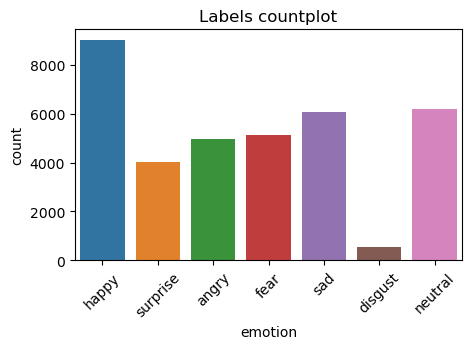

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (5,3)
#sns.set_theme(style='darkgrid')
sns.barplot(n_tab.drop([7]),x='emotion',y='data')
plt.title('Labels countplot')
plt.ylabel('count')
plt.xticks(rotation = 45) 
plt.show()

Si osserva che il numero di dati per il *disgusto* è nettamente inferiore alle altre categoria. Questo potrebbe essere un problema, perchè si potrebbe avere un bias nella creazione dei modelli di rete neurale. Si potrebbe anche decidere di non considerare questa categoria di espressioni facciali, per creare un modello molto efficace nel riconoscimento delle altre categorie. Ho reputato però più interessante, ai fini del progetto computazionale, tenere il dataset così com'è e andare a vedere quali sono i possibili effetti di uno sbilanciamento del genere.

#### Caricamento e manipolazione dei dati

Sfruttando sempre le funzioni del pacchetto `os` procediamo effettivamente a caricare il dataset di immagini. Tramite una serie di operazioni di manipolazione (fra cui lo *shuffling*) dei dati, si ottengono quattro array di quattro array di dati, cioè le *feature* e i *label* per i set di *train* e di *test*.

Tramite la classe `Image` del pacchetto `PIL` (Python Imaging Library) possiamo caricare le immagini (che sono in formato `.jpg`). Queste vengono salvate come delle matrici $48\times48$ di numeri interi da $0$ a $255$, che stanno a indicare il grado di opacità di ogni pixel nella scala di grigi ($0$ per il nero, $255$ per il bianco).

In [3]:
from PIL import Image

# charge the image dataset as an array of 48x48 matrices
# load_data loads the data in a dictionary of categories
def load_data(image_dir):
    assert type(image_dir)==str
    X_dict={}
    for i_em,emotion in enumerate(np.array(os.listdir(image_dir))):
        X_dict[emotion]=np.zeros((len(os.listdir(pj(image_dir,emotion))),48,48))
        for i_file,image_file in enumerate(np.array(os.listdir(pj(image_dir,emotion)))):
            filename=pj(image_dir,emotion,image_file)
            image = Image.open(filename).convert('L')
            ydim, xdim = image.size
            pix=image.load();
            data = np.zeros((xdim, ydim))
            for j in range(ydim):
                for k in range(xdim):
                    data[k,j]=pix[j,k]
            X_dict[emotion][i_file]=data
    return X_dict

# shuffle features and targets simoultaneously
def shuffle_data(X,Y):
    assert len(X)==len(Y)
    perm=np.random.permutation(len(X))
    return X[perm],Y[perm]

# LOAD
X_train_dict=load_data(pj(data_dir,'train'))
X_test_dict=load_data(pj(data_dir,'test'))

"""

# delete disgust images
del X_train_dict['disgust']
del X_test_dict['disgust']
del Y_train_dict['disgust']
del Y_test_dict['disgust']
"""

n_categories=len(X_train_dict.keys())

# dict to unique array
X_train=np.concatenate(tuple(X_train_dict.values()))
X_test=np.concatenate(tuple(X_test_dict.values()))

# dictionary to interpret the classification integer outputs
emotions={i_em:em for i_em,em in enumerate(X_train_dict.keys())}

Y_train=np.concatenate([np.full(len(X_train_dict[emotions[i_em]]),i_em) for i_em in emotions.keys()])
Y_test=np.concatenate([np.full(len(X_test_dict[emotions[i_em]]),i_em) for i_em in emotions.keys()])

# data shape info
image_size=len(X_train[0][0])
pixel_number=image_size**2

# set seed
np.random.seed(2)

# shuffle
X_train,Y_train=shuffle_data(X_train,Y_train)
X_test,Y_test=shuffle_data(X_test,Y_test)

# reshape matrices
n_train=len(X_train)
n_test=len(X_test)
X_train_lin=X_train.reshape(n_train,-1)
X_test_lin=X_test.reshape(n_test,-1)

print(X_train.shape)
print(X_test.shape)

(28709, 48, 48)
(7178, 48, 48)


#### Esempi di immagini
Di seguito sono mostrati alcuni esempi di immagini con il rispettivo *label*, presi dal set di *training*. Dapprima si ha una sequenza di 10 immagini casuali, poi un esempio di immagine per ogni categoria di emozione.

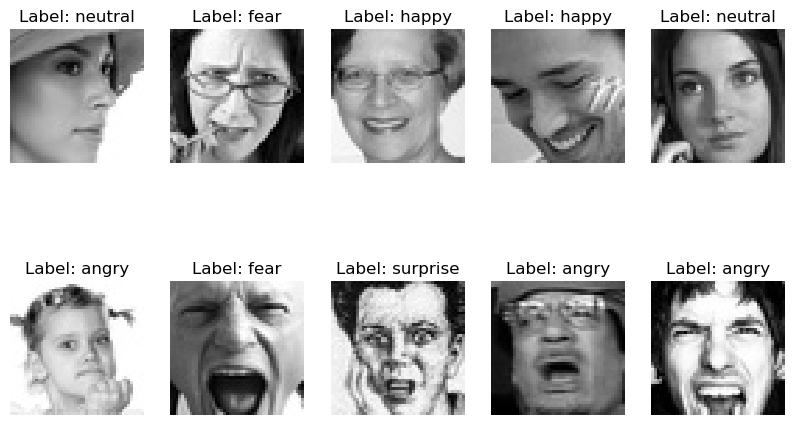

In [4]:
def print_images(pixels,labels,x_grid,y_grid):
    plt.figure(figsize=(10,3*y_grid))
    for i, image in enumerate(pixels):
        plt.subplot(y_grid, x_grid, i+1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
        plt.title("Label: " + emotions[labels[i]])
    plt.show()

np.random.seed(1150)
image_index=np.random.randint(0,len(X_train),10)
print_images(X_train[image_index],Y_train[image_index],5,2)

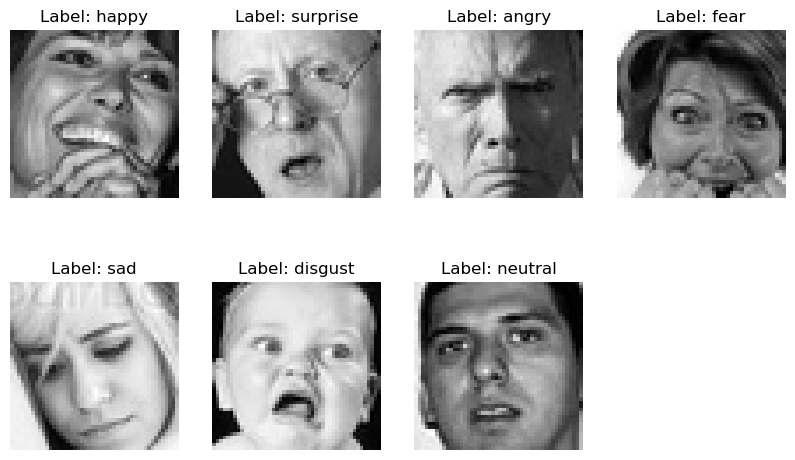

In [5]:
image_index=np.array([np.where(Y_train==y)[0][1] for y in np.unique(Y_train)])
print_images(X_train[image_index],Y_train[image_index],4,2)

Abbiamo caricato i dati e li abbiamo disposti in opportuni array (`X_train,Y_train,X_test,Y_test`). Questi sono il formato standard degli input delle varie classi e metodi di Keras, pacchetto per il machine learning in Python.

Ora possiamo procedere con l'implementazione dei due algoritmi di rete neurale che vogliamo sperimentare in questo progetto.

### Feed-Forward Neural Network (**FFNN**)

Una Feed Farward Neural Network (FFNN) è una rete neurale in cui si hanno unna serie di strati (*layer*) di nodi, in cui ogni nodo dei vari layer prende in input i valori uscenti da tutti i nodi del layer precedente. L'input scorre soltanto in una direzione. In questo modo l'output viene predetto come combinazione lineare di valori opportunamente pesati e attivati da una certa funzione di attivazione non lineare. 

Si distinguono tre tipi di layer:

- **Layer di input**: sono i valori di input del modello, di fatto nel nostro caso sono le $48 \dot 48 =2034$ componenti delle matrici di pixel di input.
- **Hidden Layer**: sono i vari nodi intermedi, che prendono come input i valori uscenti dal layer precedente e dopo averli manipolati restituiscono un nuovo valore al layer successivo.
- **Output Layer**: è il layer finale, riceve input dal precedente *hidden layer* e restituisce l'output del modello, sempre attraverso una combinazione lineare e una funzione di attivazione.

Si può sintetizzare la rete neurale come:

$$
\begin{cases}
z_j^l=\sum_i^{m(l)}w^l_{i,j}x_i+b_j \quad\quad \text{se l=1}\\ \\
z_j^l=\sum_i^{m(l)}w^l_{i,j}h_i^{l-1}+b_j \quad\quad \text{se l>1,} \quad \text{con} \quad h_i^{l-1}=f(z_i^{l-1}) \\ \\
\hat{y}_k=a(z_k^L) \quad \quad \text{se l=L}
\end{cases}
$$

Dove $f$ e $a$ sono dette funzioni di attivazione, e $w_{i,j}$, $b_j$ sono i pesi e bias della rete in ciascun layer. Le $x$ sono le *feature* di input, le $y$ sono i *label* di output.

L'efficacia di una rete neurale nel rappresentare un modello è espressa concretamente dai *Teoremi di approssimazione universale*. Secondo questi teoremi, sotto opportune condizioni e ipotesi, le reti neurale sono in grado di approssimare a piacere un qualsiasi tipo di funzione da uno spazio $\mathbf{R^P}$ a uno spazio $\mathbf{R^Q}$. Quindi sono perfette per rappresentare il modello che ci serve.

I parametri $w$ e $b$ sono da modificare in maniera opportuna per poter descrivere il modello che ci interessa. Per farlo è necessario stabilire una funzione di costo, cioè una funzione in grado di confrontare l'output del nostro modello con il vero *label* del dataset per ogni dato. L'obiettivo è trovare i valori dei parametri che minimizzano la funzione di costo. Questo viene poi fatto con degli opportuni algoritmi di ottimizzazione.

#### Decomposizione PCA: Riduzione dimensionale

Una questione importante nel progettare l'architettura di una rete neurale è il numero di parametro, nel senso di numero di peso e bias coinvolti nel modello. Questa cosa, per una rete FFNN, dipende interamente dalla dimensione dello spazio di input e output e dal numero di layer nascosti e di nodi per ciascuno di tali layer. L'idea è che aumentando la dimensione dello spazio dei parametri in gioco aumenta anche la difficoltà a minimizzare la funzione di costo, cioè aumentano i tempi computazionali. Nelle FFNN, rispetto, alle CNN che vedremo dopo, si ha tendenzialmente una grande quantità di pesi, perchè tutti i nodi di ogni layer sono connessi a tutti i nodi dei layer precedente e successivo. 

Una cosa che si osserva concretamente poi è che maggiore è la dimensione dello spazio delle features, maggiore deve essere la complessità della rete neurale, sia rispetto alla profondità che rispetto alla larghezza (i.e. numero di layer e di nodi per pgni layer), per poter modellizzare al meglio la funzione che si vuole riprodurre.

Si trova di tutte le informazioni contenuti nei dati di input, solo una certa parte sono davvero essenziali per creare il modello di interesse, soprattutto in problemi di classificazione, come in questo caso. Per questo esistono metodi di *riduzione dimensionale* per diminuire la quantità di dati di input, tenendo solo le caratteristiche cruciale negli input.

Uno di questi metodi è la Principal Component Analysis (PCA), in cui si cerca di proiettare lo spazio delle features $\mathbf{R^P}$ a un sottospazio p-dimensionale (p<P). Il criterio è quello di tenere solo le princpali direzioni dello spazio delle features che maggiormente contribuiscono alla varianza del dataset. Questo si fa diagonalizzando la matrice di correlazione del dataset (di *training*), $C[x]$.

La classe `PCA` del pacchetto Scikit Learn implementa i vari algoritmi della PCA. Qui sotto è riportata una analisi schematica per capire a quante componenti è utile ridurre lo spazio delle features tenendo comunque un contributo significativo alla varianza del dataset.

In [6]:
from sklearn.decomposition import PCA

# pixel number = 2304
pca = PCA(pixel_number)
pca.fit(X_train_lin)

Z_train=pca.transform(X_train_lin)
pca_new = PCA(pixel_number)
pca_new.fit(Z_train)

pca_new_cov=pca_new.get_covariance()

In [7]:
var=np.array([pca_new_cov[i,i] for i in range(2304)])
cum_var=np.zeros(len(var))
for i in range(len(var)):
    cum_var[i]=(var[:i].sum())
cum_var=cum_var/var.sum()

In [8]:
perc_target=np.array([.90,.95,.99,.995,.997])
n_perc=np.zeros(len(perc_target))
for i,perc in enumerate(perc_target):
    n_perc[i]=np.where(cum_var>=perc)[0][0]

perc_df=pd.DataFrame({'percentage':perc_target*100.,'components':n_perc})
perc_df.components=perc_df.components.astype(int)
display(perc_df)

,percentage,components
0,90.0,104
1,95.0,257
2,99.0,902
3,99.5,1228
4,99.7,1452


Nel `DataFrame` riportato sopra si pssono osservare il numero di componenti necessarie per avere una certa porzione della varianza. Di seguito è riportato un grafico che mette in luce in maniera più chiara questo tipo di analisi.  

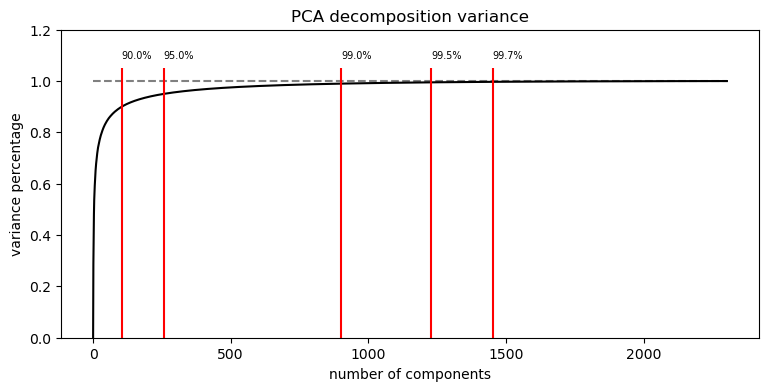

In [9]:
plt.figure(figsize = (9, 4))
plt.title('PCA decomposition variance')
plt.ylim(0.,1.2)
plt.ylabel('variance percentage')
plt.xlabel('number of components')
plt.hlines(y=1., xmin=0, xmax=pixel_number, colors='gray', linestyles='--')
plt.plot(cum_var,color='black')

plt.vlines(x=n_perc, ymin=0, ymax=1.05, color = 'r')
for i, x in enumerate(n_perc):
    plt.text(x,1.1,'%s%%' % ("{:.1f}".format(perc_target[i]*100.)),
             rotation=0, verticalalignment='center',fontsize=7)

plt.show()

Si vede che tenendo le prime $900$ componenti che contribuiscono maggiormente alla varianza del dataset si tiene conto del $99\%$ della varianza del dataset. Per sviluppare la rete FFNN si è quindi scelto di tenere le prime $1000$ componenti (su $2304$). 

Di seguito sono riportate due immagini di esempio per avere una idea qualitativa dell'efficacia della PCA. Le due immagini sopra sono ottenute prendendo solo le componenti di ogni immagine sul piano delle prime mille direzioni principali della PCA. Posso essere confrontate con quelle sotto che invece sono le immagini originali. Si può notare una leggera perdita di definizione, però sono sostanzialmente simili.

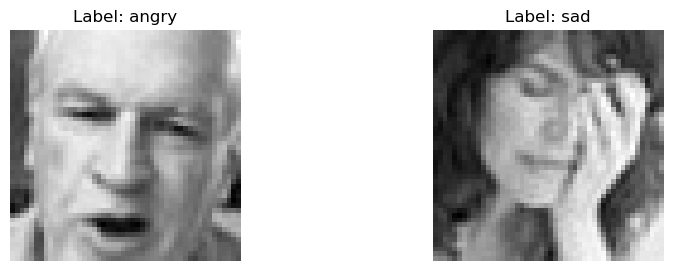

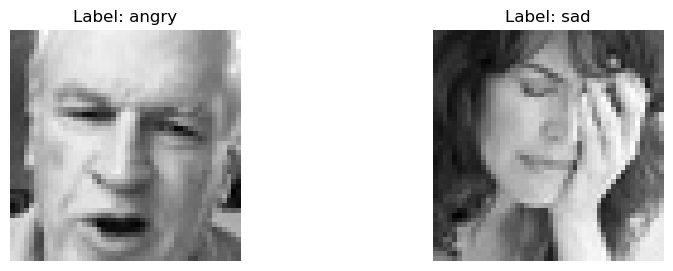

In [10]:
examples=np.random.randint(0,len(X_train),2)
n_components=1000

Z_ex=Z_train[examples].copy()
Z_ex[:,n_components:]=0
X_ex=pca.inverse_transform(Z_ex)
X_ex=np.reshape(X_ex,(-1,48,48))
print_images(X_ex,Y_train[examples],2,1)
print_images(X_train[examples],Y_train[examples],2,1)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components)
pca.fit(X_train_lin)

Z_train=pca.transform(X_train_lin)
Z_test=pca.transform(X_test_lin)

#### Architettura della rete 

- Dopo vari test con diverse architetture di rete FFNN diverse sono arrivato alla seguente architetturea, con 6 *hidden layer*. Il numero di nodi per ogni layer diminuisce fino all'ultimo layer.

- In tutti i layer nascosti ho usato come funzione di attivazione la ReLU
  $$
  ReLU(x)=\max{(\{0,x\})}
  $$

Principalmente mi sono accorto che funzioni di attivazione limitate sia inferiormente che superiormente non funzionavano molto bene. Ho diciso però di non indagare troppo l'efficacia di altre funzioni di attivazione non limitate.

- Per il layer di output ho usato come funzione di attivazione la funzione Softmax, particolarmente indicata per i problemi di classificazione categorica.

  $$
  s_i(y_1,\dots,y_q)=\frac{e^{y_i}}{\sum_{j} e^{y_j}}
  $$

  I label di ouput sono così trasformati in vetto di $q$ componenti ($q$ è il numero di categorie) in cui tutte le componenti sono nulle trane una posta uguale a 1.

- Come algoritmo di ottimizzazione ho usato *Adam*. Questo si è rivelato più efficiente rispetto a un normale Stochastic Gradient Descent, si è rivelato necessario che il learning rate diminuisca all'aumentare delle epoche. La scelta del learning rate iniziale è stata effettuata tramite il confronto fra le accuratezze del modello con diversi iperparametri. 

- La rete è stata allenata dividendo il dataset in mini-batch. Questo permette di uscire da minimi locali durante la fase di training e anche di rendere computazionalmente più efficiente il processo.

- Si utilizza un regolarizzatore di tipo *l2* per evitare che i valori dei parametri crescano troppo. Il parametro di regolarizzazione $\lambda$ è stato anch'esso scelto tramite il confornto dell'accuratezza ottenuta con diversi iperparametri.

- Il miglior modello ottenuto durante tutto il training viene salvato tramite una opportuna `callback` di keras. Per miglior modello si intende quello con una maggiore accuratezza di validazione. 

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from tensorflow.keras.callbacks import ModelCheckpoint

2023-12-20 17:03:22.840270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
mean=Z_train.mean()
std= Z_train.std()

Z_train=(Z_train-mean)/std
Z_test=(Z_test-mean)/std

Y_train_vec=to_categorical(Y_train)
Y_test_vec=to_categorical(Y_test)

print(Z_train.shape)
print(Y_train_vec.shape)
print(Z_test.shape)
print(Y_test_vec.shape)

(28709, 1000)
(28709, 7)
(7178, 1000)
(7178, 7)


In [14]:
eta=0.001
lmbd=0.0001
dropout_rate=0.0

model_FFNN = Sequential()

2023-12-20 17:03:28.547377: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model_FFNN.add(Dense(2000, activation='relu', kernel_regularizer=regularizers.l2(lmbd),
              input_shape=(n_components,)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(1400, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(700, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
model_FFNN.add(Dropout(dropout_rate))

model_FFNN.add(Dense(n_categories, activation='softmax'))

In [16]:
opt = optimizers.Adam(learning_rate=eta)

model_FFNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_FFNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              2002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1400)              2801400   
                                                                 
 dropout_1 (Dropout)         (None, 1400)              0         
                                                                 
 dense_2 (Dense)             (None, 700)               980700    
                                                                 
 dropout_2 (Dropout)         (None, 700)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               2

In [17]:
checkpoint = ModelCheckpoint(
    filepath='./checkpoints/checkpoint_FFNN.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [18]:
import time
from datetime import timedelta
#warnings.filterwarnings("ignore")

start=time.time()
np.random.seed(845)

history = model_FFNN.fit(
    Z_train,
    Y_train_vec,
    epochs=30, 
    validation_data=(Z_test, Y_test_vec),
    batch_size=64, 
    verbose=2,
    callbacks=[checkpoint]
)

end=time.time()

Epoch 1/30
449/449 - 60s - loss: 1.9372 - accuracy: 0.3458 - val_loss: 1.7471 - val_accuracy: 0.3852 - 60s/epoch - 134ms/step
Epoch 2/30
449/449 - 66s - loss: 1.6766 - accuracy: 0.4161 - val_loss: 1.7139 - val_accuracy: 0.4016 - 66s/epoch - 147ms/step
Epoch 3/30
449/449 - 69s - loss: 1.5725 - accuracy: 0.4618 - val_loss: 1.6795 - val_accuracy: 0.4270 - 69s/epoch - 153ms/step
Epoch 4/30
449/449 - 66s - loss: 1.4912 - accuracy: 0.5099 - val_loss: 1.7156 - val_accuracy: 0.4356 - 66s/epoch - 148ms/step
Epoch 5/30
449/449 - 62s - loss: 1.3988 - accuracy: 0.5659 - val_loss: 1.7980 - val_accuracy: 0.4383 - 62s/epoch - 139ms/step
Epoch 6/30
449/449 - 64s - loss: 1.3080 - accuracy: 0.6195 - val_loss: 1.8277 - val_accuracy: 0.4514 - 64s/epoch - 141ms/step
Epoch 7/30
449/449 - 64s - loss: 1.2143 - accuracy: 0.6726 - val_loss: 2.0103 - val_accuracy: 0.4572 - 64s/epoch - 143ms/step
Epoch 8/30
449/449 - 63s - loss: 1.1225 - accuracy: 0.7266 - val_loss: 2.2373 - val_accuracy: 0.4492 - 63s/epoch - 141

In [19]:
print('Training time:')
print(str(timedelta(seconds=end-start)))

Training time:
0:33:22.233978


#### Analisi del training

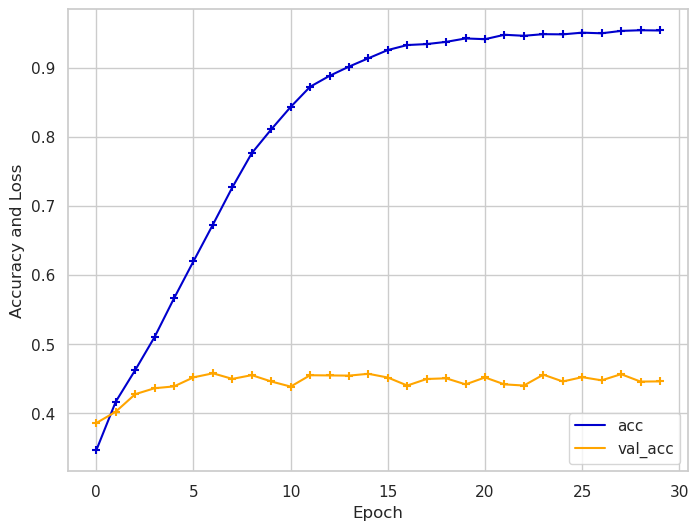

In [20]:
x=np.linspace(0,len(history.history["loss"])-1, num=len(history.history["loss"]))
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='acc', color='mediumblue')
plt.plot(history.history['val_accuracy'], label = 'val_acc', color='orange')
plt.scatter(x, history.history['accuracy'], marker='+', color='mediumblue')
plt.scatter(x, history.history['val_accuracy'], marker='+', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [21]:
print("FFNN Final Model:")
print("Training Accuracy: " + str(format(history.history['accuracy'][-1], '.3f')))
print("Testing Accuracy: " + str(format(history.history['val_accuracy'][-1], '.3f')))

FFNN Final Model:
Training Accuracy: 0.954
Testing Accuracy: 0.446


Come si può osservare dai risulati sopra con una FFNN di questo tipo si fa presto overfitting, con il modello che arriva ad avere un ottima accuratezza sul dataset di *training* ma che rimane fisso al $45\%$ sul dataset di *test*. 

Faccio notare che in questa rete ci sono circa $6$ milioni di parametri. Ho provato anche architetture notevolmente diverse, con meno layer. Se questa arriva fino al $45\%$ di accuratezza, ho trovato che una rete con circa $300 \: 000$ parametri (un ordine di grandezza in meno) arriva ad avere una accuratezza di circa il $40\%$.

### Convolutional Neural Network - CNN

Le *Convolutional Neural Network* (CNN) sono reti neurali particolarmente indicate per i problemi di riconoscimento di immagini. La proprietà chiave che si vuole sfruttare è il fatto che nelle immagini molti elementi chiave che permettono la distinzione fra una categoria e un' altra sono locali, legate a un numero ridotto di pixel. Questo gruppo di pixel però potrebbe trovarsi in regioni diverse da caso a caso nelle immagini. Quello che serve per sfruttare questo tipo di proprietà è una convoluzione. Cioè si hanno dei pesi come nelle reti *Feed-Forward*, però questi vanno a moltiplicare solo sottogruppi di pixel in tutta l'immagine, passando da un layer all'altro. 
Si parla di convoluzione discreta, cioè una operazione del tipo.

$$
S(m,n)=\sum_{i,j=-q}^q x(m-i,n-j)w(i,j)
$$

Il ruolo dei pesi $w(i,j)$ è quello di essere dei filtri per l'immagine, che rimane bidimensionale. Ogni *layer* di una CNN di fatto è costituito da un certo numero di diversi filtri, che mettono in luci alcuni aspetti dell'immagine piuttosto che altri.
Rispetto alle FFNN vengono introdotti i seguenti tipi di layer.

- *Convolutional layer*: usato per la trasformazione di un volume di input in un volume di features date da convoluzioni di quello iniziale.
- *Maxpooling layer*: è il layer di riduzione dimensionale in cui, considerata una certa regione di features, si prende una sua media o il valore minimo o il valore massimo o funzioni di queste.

L'idea è quella cper cui applicando in maniera successiva questi tipi di layer si arriva ad averne uno che può essere effettivamente pensato come un *layer* monodimensionale. A partire da quest'ultimo si ha quindi poi una normale FFNN per ottenere l'effettivo output della rete neurale.

#### Architettura della rete

Per la CNN ho tenuto lo stesso algoritmo di ottimizzazione (*Adam*) con gli stessi iperparametri di learning rate e di regolarizzazione. Si effettua sempre una suddivisione in mini-batch per avere una componente stocastica nel processo di training e si ha sempre una `callback` per salvare il modello più performante durante la fase di training.

Una particolare novità introdotta per ottenere una CNN funzionante sono i layer di *Dropout*. Specificando un certo rate di disattivazione, questi layer permettono a ogni step di discesa del gradiente di "spegnere" alcuni nodi di un certo layer, con una probabilità definita dal rate. Quindi a ogni epoca i vari layer vengono allenati tenendone alcuni spenti. Questo rende più lento l'allenamento di tutta la rete, ma permette di evitare l'overfitting, e per questo dataset si è rivelato essenziale, garantendo di arrivare a una accuratezza maggiore del $5\%$ rispetto al caso in cui non sono stati messi.
Si è osservato in particolare che i layer di Dropout sono particolarmente essenziali per quanto riguarda la parte convoluzionale della rete, per cui in questi casi si è tenuto un alto dropout rate.

Si è usata inoltre la Batch Normalization, cioè a ogni layer della rete convoluzionale gli input venogno centrati e normalizzati.

In [22]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical 
import tensorflow as tf

In [23]:
Y_train_vec=to_categorical(Y_train)
Y_test_vec=to_categorical(Y_test)

print(X_train.shape)
print(Y_train_vec.shape)
print(X_test.shape)
print(Y_test_vec.shape)

(28709, 48, 48)
(28709, 7)
(7178, 48, 48)
(7178, 7)


In [24]:
eta=0.001
lmbd=0.0001
dropout_rate_c=0.4
dropout_rate_f=0.15

In [25]:
model_CNN = Sequential()

model_CNN.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(lmbd),
                     input_shape=(48, 48,1)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(dropout_rate_c))

model_CNN.add(Conv2D(64,(4,4),activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(dropout_rate_c))

model_CNN.add(Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(dropout_rate_c))

model_CNN.add(Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(dropout_rate_c))

model_CNN.add(Flatten())

model_CNN.add(Dense(240,activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(Dropout(dropout_rate_f))

model_CNN.add(Dense(120,activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(Dropout(dropout_rate_f))

model_CNN.add(Dense(60,activation='relu',kernel_regularizer=regularizers.l2(lmbd)))
model_CNN.add(Dropout(dropout_rate_f))

model_CNN.add(Dense(n_categories, activation='softmax',kernel_regularizer=regularizers.l2(lmbd)))

In [26]:
opt = optimizers.Adam(learning_rate=eta)

model_CNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 64)      

In [27]:
checkpoint = ModelCheckpoint(
    filepath='./checkpoints/checkpoint_CNN.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [28]:
import time
from datetime import timedelta
#warnings.filterwarnings("ignore")

start=time.time()
np.random.seed(323)

history = model_CNN.fit(
    X_train/255.,
    Y_train_vec,
    epochs=50,
    validation_data=(X_test/255., Y_test_vec),
    batch_size=64,
    verbose=2,
    callbacks=[checkpoint]
)

end=time.time()

Epoch 1/50
449/449 - 94s - loss: 1.8881 - accuracy: 0.2585 - val_loss: 1.8451 - val_accuracy: 0.2765 - 94s/epoch - 209ms/step
Epoch 2/50
449/449 - 97s - loss: 1.7168 - accuracy: 0.3547 - val_loss: 1.6449 - val_accuracy: 0.3927 - 97s/epoch - 215ms/step
Epoch 3/50
449/449 - 86s - loss: 1.6090 - accuracy: 0.4149 - val_loss: 1.5029 - val_accuracy: 0.4544 - 86s/epoch - 192ms/step
Epoch 4/50
449/449 - 89s - loss: 1.5313 - accuracy: 0.4474 - val_loss: 1.6394 - val_accuracy: 0.4046 - 89s/epoch - 198ms/step
Epoch 5/50
449/449 - 85s - loss: 1.4879 - accuracy: 0.4716 - val_loss: 1.3943 - val_accuracy: 0.4990 - 85s/epoch - 189ms/step
Epoch 6/50
449/449 - 87s - loss: 1.4505 - accuracy: 0.4866 - val_loss: 1.3754 - val_accuracy: 0.5109 - 87s/epoch - 194ms/step
Epoch 7/50
449/449 - 86s - loss: 1.4160 - accuracy: 0.5016 - val_loss: 1.3422 - val_accuracy: 0.5283 - 86s/epoch - 191ms/step
Epoch 8/50
449/449 - 85s - loss: 1.3964 - accuracy: 0.5147 - val_loss: 1.3313 - val_accuracy: 0.5242 - 85s/epoch - 188

In [35]:
print('Training time:')
print(str(timedelta(seconds=end-start-8520)))

Training time:
1:14:52.422072


##### Backup

###### Model

In [30]:
model_CNN.save('./models/model_CNN.keras')

###### History

In [31]:
np.save('./models/history_CNN.npy',history.history)

In [32]:
import numpy as np
history_dict=np.load('./models/history_CNN.npy',allow_pickle='TRUE').item()

#### Analisi del training

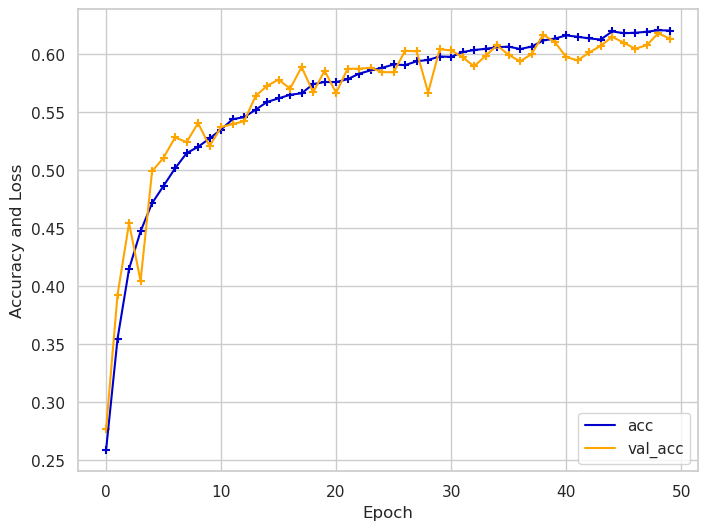

In [33]:
x=np.linspace(0,len(history.history["loss"])-1, num=len(history.history["loss"]))
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='acc', color='mediumblue')
plt.plot(history.history['val_accuracy'], label = 'val_acc', color='orange')
plt.scatter(x, history.history['accuracy'], marker='+', color='mediumblue')
plt.scatter(x, history.history['val_accuracy'], marker='+', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [ ]:
x=np.linspace(0,len(history.history["loss"])-1, num=len(history.history["loss"]))
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='acc', color='mediumblue')
plt.plot(history.history['val_accuracy'], label = 'val_acc', color='orange')
plt.scatter(x, history.history['accuracy'], marker='+', color='mediumblue')
plt.scatter(x, history.history['val_accuracy'], marker='+', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [ ]:
print("CNN Final Model: ")
print("Training Accuracy: " + str(format(history.history['accuracy'][-1], '.3f')))
print("Testing Accuracy: " + str(format(history.history['val_accuracy'][-1], '.3f')))

Si può osservare che utilizzando una CNN si riesce ad arrivare a più del $60\%$ di accuratezza nel se di validazione. Questo esempio mette in in luce come una CNN sia particolarmente necessaria per un problema di riconoscimento di immagini. Qualitativamente, per quanto riguarda le espressioni facciali, si può forse intuire che i dettagli di un volto che permettono di capire le emozioni di una persona sono dei dettagli molto piccoli e locali. Per cui solo la CNN può cogliere questo aspetto000.

Comunque è significativo che anche con una CNN non sia stato in grado di ottenere accurratezze paritcolarmente superiori al $60/%$, che non è un valore particolarmente alto. In generale ho provato a dare un occhio ad alcuni codici pubblicati online che propongono algoritmi per modelizzare questo dataset.

Prima di fare ipotesi su quale possa essere il problema può essere interessante dare un occhio alla Confusion Matrix del del miglior modell raggiunto durante il training

#### Confusion Matrix

In [36]:
from tensorflow.keras.models import load_model

# Best model
model_CNN_best=load_model('./checkpoints/checkpoint_CNN.keras')

In [55]:
Y_pred_vec=model_CNN_best.predict(X_test/255.)
Y_pred=np.argmax(Y_pred_vec,axis=1)

225/225 [==============================] - 21s 93ms/step


In [94]:
from sklearn import metrics

mat = metrics.confusion_matrix(Y_test, Y_pred)
cm=pd.DataFrame(mat.T,
               columns=['happy','surprise','angry','fear','sad','disgust','neutral'],
               index=['happy','surprise','angry','fear','sad','disgust','neutral'])
cmperc=pd.DataFrame(cm/cm.sum()).round(3)

display(cm)
display(cmperc)

,happy,surprise,angry,fear,sad,disgust,neutral
happy,1478,39,49,36,58,5,80
surprise,44,660,27,147,29,4,23
angry,49,20,499,133,112,39,68
fear,36,52,61,266,84,5,34
sad,90,37,224,362,810,10,345
disgust,0,1,6,4,2,44,3
neutral,77,22,92,76,152,4,680


,happy,surprise,angry,fear,sad,disgust,neutral
happy,0.833,0.047,0.051,0.035,0.047,0.045,0.065
surprise,0.025,0.794,0.028,0.144,0.023,0.036,0.019
angry,0.028,0.024,0.521,0.130,0.090,0.351,0.055
fear,0.020,0.063,0.064,0.260,0.067,0.045,0.028
sad,0.051,0.045,0.234,0.354,0.650,0.090,0.280
disgust,0.000,0.001,0.006,0.004,0.002,0.396,0.002
neutral,0.043,0.026,0.096,0.074,0.122,0.036,0.552


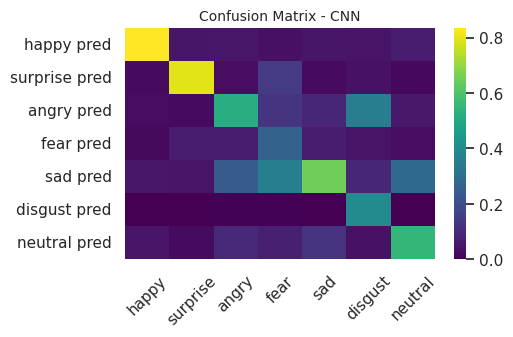

In [95]:
sns.heatmap(cmperc, annot=False,  cmap="viridis", fmt='g')
positions = (0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5)
labels_x = ('happy','surprise','angry','fear','sad','disgust','neutral')
labels_y = ('happy pred','surprise pred','angry pred','fear pred','sad pred','disgust pred','neutral pred')

plt.title("Confusion Matrix - CNN", fontsize=10)
plt.xticks(positions, labels_x, rotation=45)
plt.yticks(positions, labels_y, rotation=0)
plt.show()

I due dataframe rappresentati sopra vanno letti nel seguente modo:
Ogni casella indica il numero di immagini appartenenti alla categoria indicata dalla colonna che sono state confuse con la categoria indicata dalla riga. Il secondo dataframe e la heat map rappresentano la stessa cosa ma in percentuale.
Guardando la Heatmap si nota che la confusion matrix è tendenzialmente diagonale. Guardando i numeri precisi però si nota che la rete neurale fa fatica prevalentemente a riconoscere immagini di **paura** e **disgusto**. In particolare le immagini di paura vengono più spesso classificate come tristezza che come paura.